In [7]:
import os
import pandas as pd

# ============================================
# 請將下面的路徑改成你的資料夾路徑，並保留全大寫格式
# 例如：DATA_DIR = "D:/PROJECTS/CSV_FILES"
DATA_DIR = "C:/USERS/NTHUILST/DESKTOP/TEST"
# ============================================

def get_sorted_csv_files(directory):
    """
    取得資料夾中所有 .csv 檔，並依照檔案的建立 (或最後修改) 時間由舊到新排序，
    回傳排序後的檔名列表。
    """
    all_files = [
        f for f in os.listdir(directory)
        if f.lower().endswith(".csv")
    ]
    sorted_files = sorted(
        all_files,
        key=lambda fname: os.path.getctime(os.path.join(directory, fname))
    )
    return sorted_files

def partition_by_stage(csv_files):
    """
    將傳入的已排序檔名列表，依照檔名中是否含 "stage1" 或 "stage2" 進行分組。
    回傳兩個列表：stage1_files, stage2_files。
    其中若檔名同時含有 stage1 與 stage2 (不常見)，會優先歸到 stage1。
    若既不含 stage1 也不含 stage2，則忽略該檔名。
    """
    stage1, stage2 = [], []
    for fname in csv_files:
        lname = fname.lower()
        if "stage1" in lname:
            stage1.append(fname)
        elif "stage2" in lname:
            stage2.append(fname)
        else:
            # 如不含 stage1 或 stage2，就跳過（不納入任何一組）
            print(f"跳過：'{fname}'（檔名不含 stage1/ stage2）")
    return stage1, stage2

def merge_value_columns(csv_files, directory):
    """
    將傳入的多個 CSV 檔案，依序把裡面的 "Value" 欄位取出（若沒有就跳過），
    再橫向合併成一個 DataFrame 並回傳。若所有檔都沒有 Value 欄，則拋錯。
    """
    value_columns = []
    used_filenames = []
    for fname in csv_files:
        full_path = os.path.join(directory, fname)
        df = pd.read_csv(full_path)
        if "Value" not in df.columns:
            print(f"注意：CSV '{fname}' 中沒有 'Value' 欄，已跳過。")
            continue

        series_value = df["Value"].reset_index(drop=True)
        value_columns.append(series_value)
        used_filenames.append(fname)

    if not value_columns:
        raise RuntimeError("錯誤：指定階段的所有 CSV 都沒有 'Value' 欄，無法合併。")

    merged_df = pd.concat(value_columns, axis=1)
    return merged_df, used_filenames

def assign_column_names(df, used_filenames):
    """
    根據實際使用到的檔案數量，對 DataFrame 欄位動態命名。
    預設前六個名稱分別為：
      train_loss, train_simple_loss, train_vlb_loss,
      val_loss,   val_simple_loss,   val_vlb_loss
    若超過六欄，會把後面的欄命名為 generic_name_1, generic_name_2, ...
    """
    base_col_names = [
        "train_loss",
        "train_simple_loss",
        "train_vlb_loss",
        "val_loss",
        "val_simple_loss",
        "val_vlb_loss"
    ]

    actual_cols = df.shape[1]
    if actual_cols > len(base_col_names):
        # 超過 6 欄：多出來的用 generic_name_n 命名
        extra = actual_cols - len(base_col_names)
        col_names = base_col_names[:] + [f"generic_name_{i+1}" for i in range(extra)]
    else:
        col_names = base_col_names[:actual_cols]

    df.columns = col_names

    print("\n以下檔案有成功擷取到 'Value' 欄並納入合併：")
    for idx, fn in enumerate(used_filenames, start=1):
        print(f"  {idx}. {fn}   → 欄位名稱：{df.columns[idx-1]}")
    print()

    return df

def process_stage(stage_name, file_list):
    """
    處理單一階段：
      1. 若該階段沒有任何檔案，則提醒並略過。
      2. 否則呼叫 merge_value_columns() 將所有檔案的 Value 欄合併，
         再呼叫 assign_column_names() 給予適當的欄名。
      3. 最後輸出成 CSV： merged_<stage_name>_values.csv
    """
    if not file_list:
        print(f"\n*** 未發現任何 '{stage_name}' 檔案，跳過此階段 ***\n")
        return

    print(f"\n------ 開始處理階段：{stage_name} ------")
    merged_df, used_fns = merge_value_columns(file_list, DATA_DIR)
    labeled_df = assign_column_names(merged_df, used_fns)

    output_filename = f"merged_{stage_name}_values.csv"
    output_path = os.path.join(DATA_DIR, output_filename)
    labeled_df.to_csv(output_path, index=False)
    print(f"已將 '{stage_name}' 合併結果輸出至：{output_path}\n")

def main():
    # 1. 讀取並排序資料夾內所有 CSV
    sorted_csvs = get_sorted_csv_files(DATA_DIR)
    print("依建立／修改時間排序後的 CSV 檔案 (由舊到新)：")
    for idx, fname in enumerate(sorted_csvs, start=1):
        ctime = os.path.getctime(os.path.join(DATA_DIR, fname))
        print(f"  {idx}. {fname}  (ctime={ctime})")
    print()

    # 2. 依 stage1、stage2 分組
    stage1_files, stage2_files = partition_by_stage(sorted_csvs)

    # 3. 分別處理 stage1 與 stage2
    process_stage("stage1", stage1_files)
    process_stage("stage2", stage2_files)

if __name__ == "__main__":
    main()


依建立／修改時間排序後的 CSV 檔案 (由舊到新)：
  1. mlsp_embedding_stage1_version_1.csv  (ctime=1748775090.0758502)
  2. mlsp_embedding_stage2_version_0.csv  (ctime=1748775096.294764)
  3. mlsp_embedding_stage2_version_0 (1).csv  (ctime=1748775108.8325596)
  4. mlsp_embedding_stage1_version_1 (1).csv  (ctime=1748775111.599273)
  5. mlsp_embedding_stage2_version_0 (2).csv  (ctime=1748775120.6897001)
  6. mlsp_embedding_stage1_version_1 (2).csv  (ctime=1748775123.311392)
  7. mlsp_embedding_stage1_version_1 (3).csv  (ctime=1748775142.2691216)
  8. mlsp_embedding_stage2_version_0 (3).csv  (ctime=1748775145.9371474)
  9. mlsp_embedding_stage1_version_1 (4).csv  (ctime=1748775161.2218194)
  10. mlsp_embedding_stage2_version_0 (4).csv  (ctime=1748775163.8455887)
  11. mlsp_embedding_stage1_version_1 (5).csv  (ctime=1748775173.9675975)
  12. mlsp_embedding_stage2_version_0 (5).csv  (ctime=1748775177.545918)
  13. merged_values.csv  (ctime=1748776010.4373906)
  14. merged_stage1_values.csv  (ctime=1748776282.849

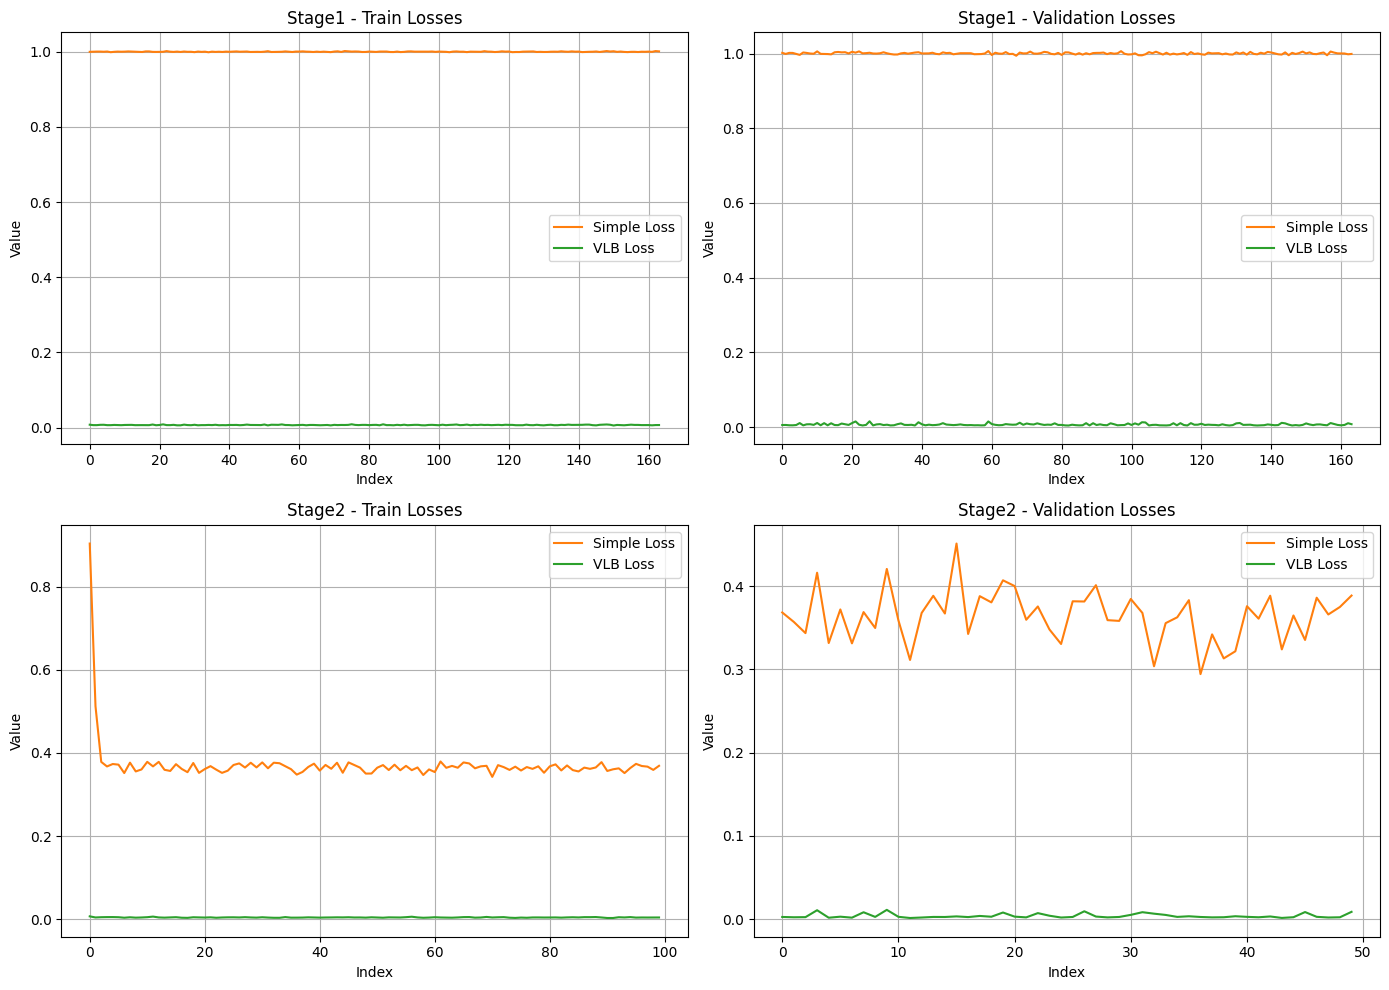

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ============================================
# 請將下面的路徑改成你存放「merged_stage1_values.csv」與
#             「merged_stage2_values.csv」的資料夾（全大寫）
# 例如：MERGED_DIR = "C:/USERS/NTHUILST/DESKTOP/TEST"
MERGED_DIR = "C:/USERS/NTHUILST/DESKTOP/TEST"
# ============================================

def load_merged_csv(stage_name):
    """
    讀取 merged_stage{1,2}_values.csv 並轉成 DataFrame
    """
    filename = f"merged_{stage_name}_values.csv"
    path = os.path.join(MERGED_DIR, filename)
    if not os.path.isfile(path):
        raise FileNotFoundError(f"找不到檔案：{path}")
    return pd.read_csv(path)


def plot_four_charts(df1, df2):
    """
    繪製 2x2 圖，每圖顯示三條曲線 (total, simple, vlb loss)
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

    # --- Stage1 - Train ---
    ax = axes[0, 0]
    # if "train_loss" in df1.columns:
    #     ax.plot(df1["train_loss"], label="Total Loss", color="tab:blue")
    if "train_simple_loss" in df1.columns:
        ax.plot(df1["train_simple_loss"], label="Simple Loss", color="tab:orange")
    if "train_vlb_loss" in df1.columns:
        ax.plot(df1["train_vlb_loss"], label="VLB Loss", color="tab:green")
    ax.set_title("Stage1 - Train Losses")
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid(True)

    # --- Stage1 - Val ---
    ax = axes[0, 1]
    # if "val_loss" in df1.columns:
    #     ax.plot(df1["val_loss"], label="Total Loss", color="tab:blue")
    if "val_simple_loss" in df1.columns:
        ax.plot(df1["val_simple_loss"], label="Simple Loss", color="tab:orange")
    if "val_vlb_loss" in df1.columns:
        ax.plot(df1["val_vlb_loss"], label="VLB Loss", color="tab:green")
    ax.set_title("Stage1 - Validation Losses")
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid(True)

    # --- Stage2 - Train ---
    ax = axes[1, 0]
    # if "train_loss" in df2.columns:
    #     ax.plot(df2["train_loss"], label="Total Loss", color="tab:blue")
    if "train_simple_loss" in df2.columns:
        ax.plot(df2["train_simple_loss"], label="Simple Loss", color="tab:orange")
    if "train_vlb_loss" in df2.columns:
        ax.plot(df2["train_vlb_loss"], label="VLB Loss", color="tab:green")
    ax.set_title("Stage2 - Train Losses")
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid(True)

    # --- Stage2 - Val ---
    ax = axes[1, 1]
    # if "val_loss" in df2.columns:
    #     ax.plot(df2["val_train_loss"], label="Total Loss", color="tab:blue")
    if "val_simple_loss" in df2.columns:
        ax.plot(df2["val_simple_loss"], label="Simple Loss", color="tab:orange")
    if "val_vlb_loss" in df2.columns:
        ax.plot(df2["val_vlb_loss"], label="VLB Loss", color="tab:green")
    ax.set_title("Stage2 - Validation Losses")
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid(True)

    plt.tight_layout()
    plt.show()


def main():
    # 1. 讀取 Stage1 與 Stage2 的合併檔案
    try:
        df_stage1 = load_merged_csv("stage1")
    except FileNotFoundError as e:
        print(e)
        return

    try:
        df_stage2 = load_merged_csv("stage2")
    except FileNotFoundError as e:
        print(e)
        return

    # 2. 繪製 4 張圖 (每張含三條曲線)
    plot_four_charts(df_stage1, df_stage2)


if __name__ == "__main__":
    main()
